In [24]:
import os
from preprocessing import *
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

matplotlib.rcParams['figure.figsize'] = [15,5]

data_contrats = pd.read_csv('train_contrats.csv',sep=";", engine="python")
data_contrats["Freq_sinistre"] = data_contrats["nombre_de_sinistre"]/data_contrats["Exposition_au_risque"]

In [2]:
 len(data_contrats["Freq_sinistre"])

87228

In [3]:
np.sum(data_contrats["Freq_sinistre"] == 0)/len(data_contrats["Freq_sinistre"])

0.9512771128536709

In [4]:
df = preprocessing(data_contrats, balance=False, train_size=1)[0]
df["Freq_sinistre"] = data_contrats["Freq_sinistre"]
#df = df[:10000]
X = df.drop("Freq_sinistre", axis=1, inplace=False).to_numpy()
Y = np.array(df["Freq_sinistre"])

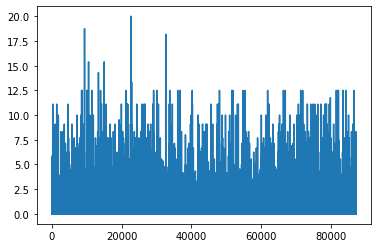

In [7]:
plt.plot( df["Freq_sinistre"])

In [5]:
df

,Classe_Age_Situ_Cont,franchise,Exposition_au_risque,ValeurPuissance,Type_Apporteur_1,Type_Apporteur_2,Type_Apporteur_3,Activite_1,Activite_2,Activite_3,...,Fractionnement_A,Fractionnement_S,Fractionnement_T,FORMULE_2,FORMULE_3,FORMULE_4,FORMULE_5,Age_du_vehicule_<= 5 ans,Age_du_vehicule_> 5 ans,Freq_sinistre
0,0.596130,0.298065,0.054645,0.695485,0.099355,0.000000,0.0,0.0,0.0,0.099355,...,0.099355,0.000000,0.000000,0.0,0.000000,0.0,0.099355,0.099355,0.000000,0.0
1,0.541791,0.216716,0.044427,0.758507,0.000000,0.108358,0.0,0.0,0.0,0.000000,...,0.000000,0.108358,0.000000,0.0,0.108358,0.0,0.000000,0.000000,0.108358,0.0
2,0.542157,0.216863,0.024939,0.759020,0.000000,0.108431,0.0,0.0,0.0,0.000000,...,0.000000,0.108431,0.000000,0.0,0.108431,0.0,0.000000,0.000000,0.108431,0.0
3,0.692925,0.277170,0.036032,0.554340,0.000000,0.138585,0.0,0.0,0.0,0.000000,...,0.000000,0.138585,0.000000,0.0,0.000000,0.0,0.138585,0.138585,0.000000,0.0
4,0.755584,0.251861,0.030223,0.503722,0.000000,0.125931,0.0,0.0,0.0,0.000000,...,0.000000,0.125931,0.000000,0.0,0.000000,0.0,0.125931,0.125931,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87223,0.612123,0.204041,0.028566,0.714143,0.102020,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.102020,0.0,0.102020,0.0,0.000000,0.102020,0.000000,0.0
87224,0.612123,0.204041,0.028566,0.714143,0.102020,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.102020,0.0,0.102020,0.0,0.000000,0.102020,0.000000,0.0
87225,0.612291,0.204097,0.016328,0.714339,0.102048,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.102048,0.0,0.102048,0.0,0.000000,0.000000,0.102048,0.0
87226,0.612123,0.204041,0.028566,0.714143,0.102020,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.102020,0.0,0.102020,0.0,0.000000,0.102020,0.000000,0.0


In [8]:
df_drop = df.drop("Freq_sinistre", axis=1)
tree = KDTree(df_drop.values)

In [9]:
def approx(df_drop, y, i, dist, ind, var):
    """
    Approximates the value of Freq_sinistre for row i 
    """
    delta_y = (y-y[i])[ind]
    gauss_weights = np.exp(-(dist) / var)
    y_hat = max(y[i]+ np.dot(delta_y, gauss_weights),0)
    return y_hat

Pour les 80000 points du jeu de données, il faut donc compter près de 400 secondes. Cela reste raisonnable. Toutefois, pour trouver la bonne valeur de la variance, il faudra faire cela plusieurs fois ce qui peut prendre du temps. On va commencer par selectionner les 1000 voisins les plus proches situés à une distance inférieure ou égale à 0.25.

In [10]:
def approx_freq(df, thresh, k, var):
    """
    approximates the Freq_sinisre column and inflate zeros
    
    parameters :
    thresh : part of the space points to select (maximum distance between a point and one of the selected neighbour)
    k : first neighbours to search in KDTree. This may affect computationnal time.
    var : vairance of the gaussian distance
    """
    Y_hat = []
    Y = df["Freq_sinistre"].values
    N=[]
    for i in range(len(df)):
        #if i % 10000 == 0:
        #    print(i)
        features = df_drop.iloc[i]
        # select k nearest neigbours
        dist, ind = tree.query(features.values.reshape(1, -1), k=k)
        # select only those not too far (to be discussed)
        n = np.sum(dist<thresh)
        dist = dist[0][:n]
        ind = ind[0][:n]
        N.append(n)
        y_hat = approx(df_drop, Y, i, dist, ind, var)
        Y_hat.append(y_hat)
    df_copy = df.copy()
    df_copy["Freq_sinistre"] = Y_hat
    return df_copy
    

In [11]:
thresh = 0.25
k=1000
var=np.exp(-3.6)
df_approx = approx_freq(df, thresh, k, var)

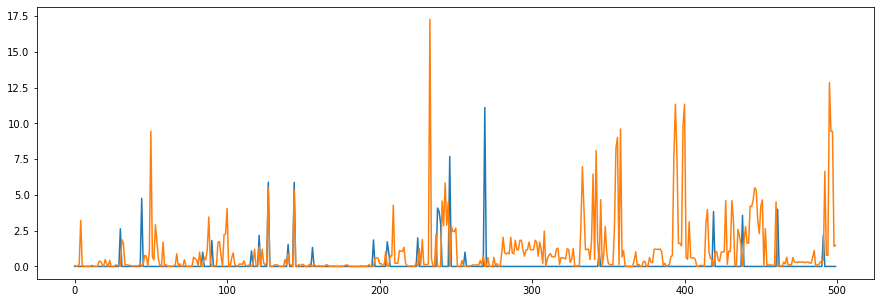

In [25]:
plt.plot(range(500),df.Freq_sinistre[:500])
plt.plot(range(500),df_approx.Freq_sinistre[:500])

In [13]:
count_zeros(df_approx["Freq_sinistre"],10**(-6))

0.09053285642224973

In [30]:
np.sqrt(np.sum((df_approx["Freq_sinistre"]-df["Freq_sinistre"])**2))

531.1936759420485

In [31]:
(np.sum((df_approx["Freq_sinistre"])**2))

246294.5162012315

In [32]:
np.sqrt(np.sum((df["Freq_sinistre"])**2))

225.59224232436486

In [15]:
np.sqrt( np.mean((df_approx["Freq_sinistre"]-df["Freq_sinistre"])**2) / (np.mean((df["Freq_sinistre"])**2)) )

2.354662866368776

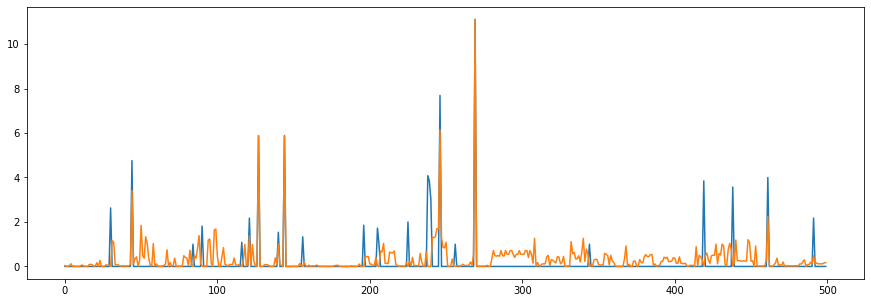

In [20]:
plt.plot(range(500),df.Freq_sinistre[:500])
plt.plot(range(500),df_approx.Freq_sinistre[:500])

In [21]:
count_zeros(df_approx["Freq_sinistre"],10**(-6))

0.08952400605310222

In [22]:
np.sqrt(np.mean((df_approx["Freq_sinistre"]-df["Freq_sinistre"])**2))

0.44228498775980885

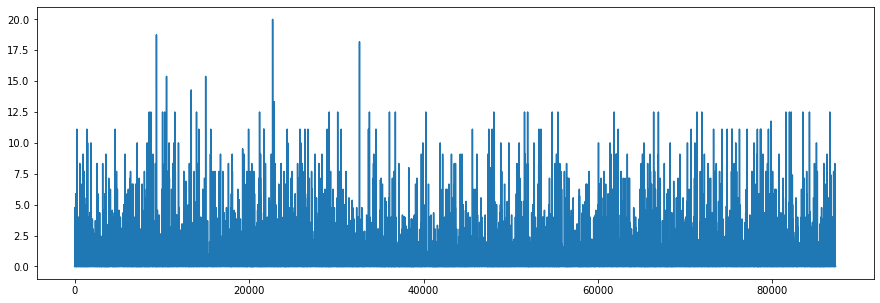

In [23]:
plt.plot(Y)

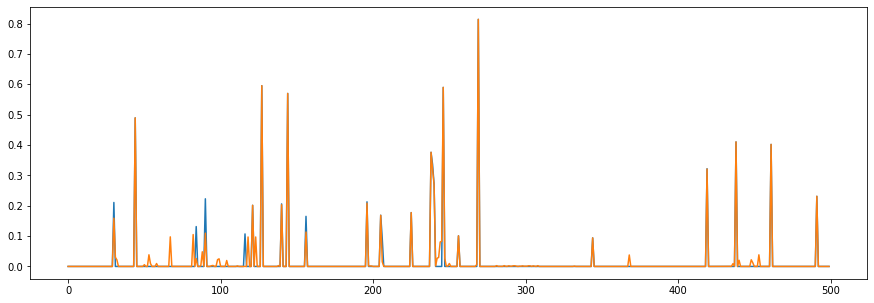

In [13]:
plt.plot(range(500),df.Freq_sinistre[:500])
plt.plot(range(500),df_approx.Freq_sinistre[:500])

In [14]:
count_zeros(df_approx["Freq_sinistre"],10**(-6))

0.8682303847388453

#### Optimisation de la variance

Les bornes n'ont pas été trouvées directement. A partir de exp(-5), plusieurs valeurs ont été testées pour trouver un intervalle qui contiennent les plateaux "hauts et bas" pour les deux mesures : nombre de zéros et erreur quadratique. Nous savions que la premiere serait décroissante en fonction de la variance, et l'autre croissante. Nous avons ainsi esayer d'avoir des intervalles qui permettaient de couvrir la majorité de valeurs prises par les deux metriques. Nous avons enfin remarqué qu'au dela de 3, les deux valeurs variaient peu, ainsi qu'en deça de -7.

In [18]:
thresh = 0.25
k=100
errList = []
countList = []
logVarList = np.linspace(-10,3,50)
#varList = [0.01,0.05,0.1,0.5,1,5]
for logVar in logVarList:
    print(f"ln(var) = {logVar}")
    var = np.exp(logVar)
    #print(var)
    df_approx = approx_freq(df, thresh, k, var)
    Y_hat = df_approx["Freq_sinistre"]
    err = np.sqrt(np.mean((Y-Y_hat)**2))
    countList.append(count_zeros(Y_hat,10**(-6)))
    errList.append(err)

ln(var) = -10.0
ln(var) = -9.73469387755102
ln(var) = -9.46938775510204
ln(var) = -9.204081632653061
ln(var) = -8.938775510204081
ln(var) = -8.673469387755102
ln(var) = -8.408163265306122
ln(var) = -8.142857142857142
ln(var) = -7.877551020408163
ln(var) = -7.612244897959183
ln(var) = -7.346938775510203
ln(var) = -7.081632653061224
ln(var) = -6.816326530612245
ln(var) = -6.551020408163265
ln(var) = -6.285714285714286
ln(var) = -6.020408163265306
ln(var) = -5.755102040816326
ln(var) = -5.489795918367347
ln(var) = -5.224489795918367
ln(var) = -4.959183673469387
ln(var) = -4.693877551020408
ln(var) = -4.428571428571428
ln(var) = -4.163265306122448
ln(var) = -3.8979591836734686
ln(var) = -3.63265306122449
ln(var) = -3.36734693877551
ln(var) = -3.1020408163265305
ln(var) = -2.836734693877551
ln(var) = -2.571428571428571
ln(var) = -2.3061224489795915
ln(var) = -2.040816326530612
ln(var) = -1.7755102040816322
ln(var) = -1.5102040816326525
ln(var) = -1.2448979591836729
ln(var) = -0.979591836734

With quadratic distance

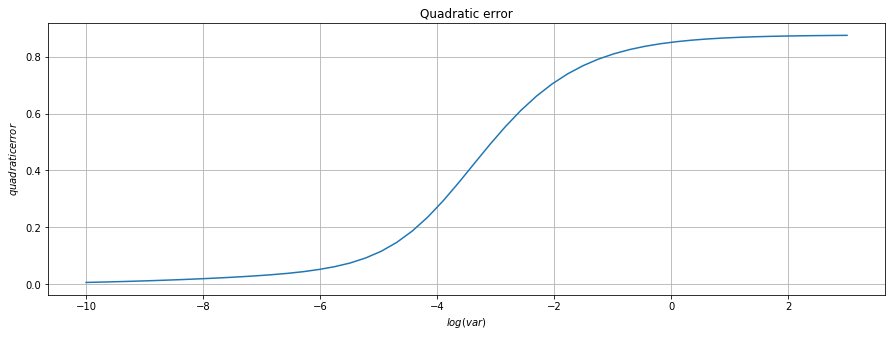

In [20]:
fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(logVarList)

plt.plot((logVarList), errList)
plt.title('Quadratic error')
plt.xlabel('$log(var)$')
plt.ylabel('$quadratic error$')
plt.grid()
plt.show()

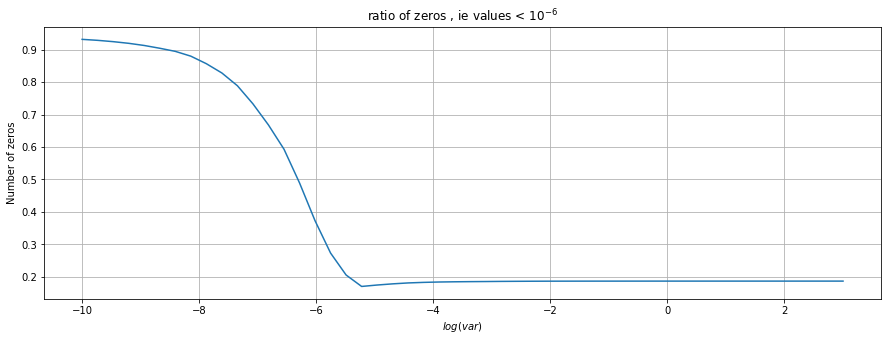

In [21]:
fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(logVarList)
plt.plot((logVarList), countList)
plt.title('ratio of zeros , ie values < $10^{-6}$')
plt.xlabel('$log(var)$')
plt.ylabel('Number of zeros')
plt.grid()
plt.show()

With euclidian distance

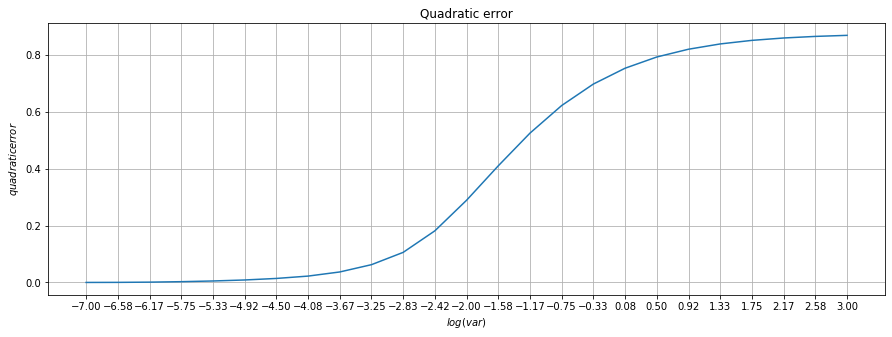

In [34]:
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(logVarList)

plt.plot((logVarList), errList)
plt.title('Quadratic error')
plt.xlabel('$log(var)$')
plt.ylabel('$quadratic error$')
plt.grid()
plt.show()

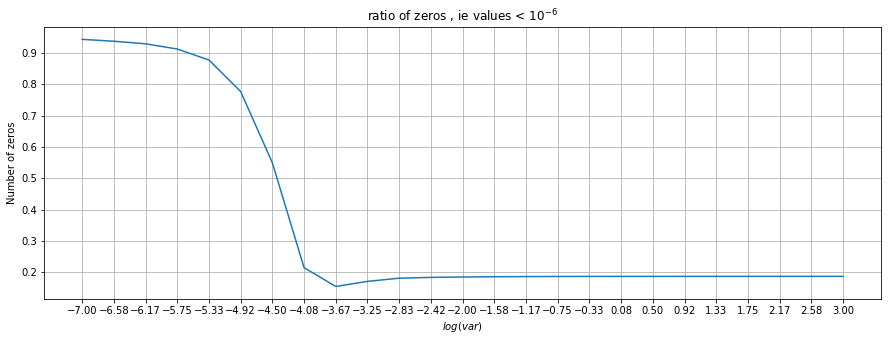

In [35]:
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(logVarList)
plt.plot((logVarList), countList)
plt.title('ratio of zeros , ie values < $10^{-6}$')
plt.xlabel('$log(var)$')
plt.ylabel('Number of zeros')
plt.grid()
plt.show()

Prendre $var=-3.67 semble être optimal. Procédons à la vérification.
Cette fois, nous sleectionnons les 10000 plus proches voisins sjitués à une distance inférieure à 0.25.

In [9]:
var = np.exp(-3.6)

In [10]:
df_approx = approx_freq(df, thresh=0.25, k=10000, var=var)

In [38]:
count_zeros(df_approx["Freq_sinistre"])

0.0901430733250791

In [39]:
err = np.sqrt(np.mean((df["Freq_sinistre"]-df_approx["Freq_sinistre"])**2))
err

0.04796854423299092

In [47]:
ari_kmeans = [1,0.42,0.70,0.65,0.66,0.49,0.45,0.62,0.56]
ari_gmm = [1,0.2,0.37,0.47,0.25,0.12,0.21,0.56,0.29]

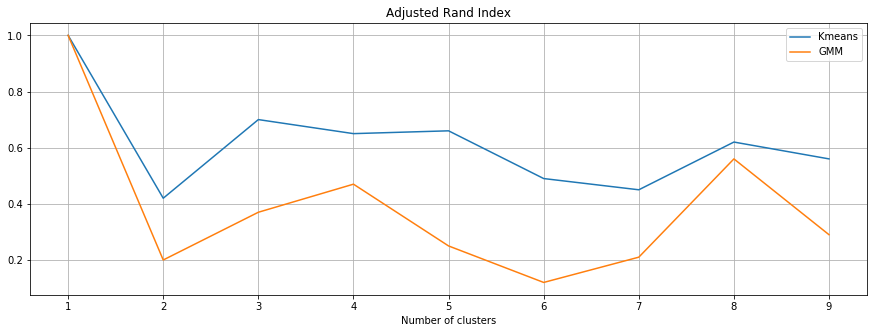

In [49]:
plt.plot(range(1,len(ari_kmeans)+1),ari_kmeans, label="Kmeans")
plt.plot(range(1,len(ari)+1),ari_gmm, label="GMM")
plt.title("Adjusted Rand Index")
plt.xlabel("Number of clusters")
plt.grid()
plt.legend()
